In [1]:
# Fernando Martinez

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

images_size = (128, 128)
batch_size = 256
latent_vector_size = 128
weight_initialization = tf.keras.initializers.HeNormal()

In [43]:
def preprocess_imgs(path, resize_shape=images_size):
    img = tf.io.read_file(path)
    decoded = tf.io.decode_jpeg(img, channels=3)
    x = tf.image.convert_image_dtype(decoded, tf.float32)
    x = tf.image.resize(x, resize_shape)
    y = x
    return x, y

def load_dataset(directory, batch_size, shuffle=True):
    file_names = os.listdir(directory); file_paths = []
    for file_name in file_names:
        file_path = os.path.join(directory, file_name)
        file_paths.append(file_path)
        
    tfdataset = tf.data.Dataset.from_tensor_slices(file_paths)
    ds = tfdataset.map(preprocess_imgs, num_parallel_calls=tf.data.AUTOTUNE)   
    ds = ds.batch(batch_size)
    return ds

import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model
from skimage.transform import resize

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid
def getFID(real_images, fake_images):
    '''
    real_images : your real images B,W,H,C
    fake_images : your fake images B,W,H,C


    '''

    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

    assert real_images.shape == fake_images.shape, ' Images should have identical shape !!'
    # convert integer to floating point values
    images1 = real_images.astype('float32')
    images2 = fake_images.astype('float32')
    # resize images
    images1 = scale_images(images1, (299,299,3))
    images2 = scale_images(images2, (299,299,3))
    # pre-process images
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)

    # fid between images1 and images2
    fid = calculate_fid(model, images1, images2) * 10
    print('FID of your Fake Output: %.3f' % fid)

Train = load_dataset('/kaggle/input/cisc6000-deep-learning-hw3/celeba/train', batch_size = batch_size)
Test = load_dataset('/kaggle/input/cisc6000-deep-learning-hw3/celeba/test', batch_size = batch_size)

## Test to check image scale

In [3]:
if tf.reduce_max([obv[0] for obv in Train.unbatch().take(70)]).numpy()==1. and tf.reduce_min([obv[0] for obv in Train.unbatch().take(70)]).numpy()==0.:
    print("Images are scaled between 0 and 1")
else:
    print("We need to rescale the images!")

2022-12-14 01:23:24.154480: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Images are scaled between 0 and 1


# L2 Model

In [4]:
def func_lantent_sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(z_mean))
    return z_mean + tf.math.multiply(tf.keras.backend.exp(z_log_var / 2), epsilon)

def Re_construction_loss(loss_type="l2"):
    if loss_type == "l2":
        def ReConstruction_loss(y_true, y_pred):
            return tf.math.abs(tf.math.subtract(y_true, y_pred))
    else: 
        def ReConstruction_loss(y_true, y_pred):
            return tf.math.square(tf.math.subtract(y_true, y_pred))
    return ReConstruction_loss

inputsL2 = tf.keras.layers.Input(shape= images_size+(3,), name="InputLayer")
vae_encoderL2 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, activation=tf.nn.leaky_relu, padding="same", kernel_initializer=weight_initialization),
            tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation=tf.nn.leaky_relu, padding="same", kernel_initializer=weight_initialization),
            tf.keras.layers.AveragePooling2D(),
            tf.keras.layers.Conv2D(8, kernel_size=3, strides=2, activation=tf.nn.leaky_relu, padding="same", kernel_initializer=weight_initialization),
            tf.keras.layers.Flatten()], name="EncoderSequence")(inputsL2)

latent_z_mean = tf.keras.layers.Dense(latent_vector_size, name="z_mean", kernel_initializer=weight_initialization)(vae_encoderL2)
latent_z_log_var = tf.keras.layers.Dense(latent_vector_size, name="z_log_var", kernel_initializer=weight_initialization)(vae_encoderL2)
latent_layer_encoder = tf.keras.layers.Lambda(func_lantent_sampling, output_shape=(latent_vector_size,))([latent_z_mean, latent_z_log_var])

VAE_model_encode_L2 = tf.keras.Model(inputsL2, latent_layer_encoder)

decoderL2 = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_vector_size,)),
            tf.keras.layers.Dense(8*8*64, kernel_initializer=weight_initialization),
            tf.keras.layers.Reshape(target_shape=(8,8,64)),
            tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation=tf.nn.leaky_relu, padding="same", kernel_initializer=weight_initialization),
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation=tf.nn.leaky_relu, padding="same", kernel_initializer=weight_initialization),
            tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation=tf.nn.leaky_relu, padding="same", kernel_initializer=weight_initialization),
            tf.keras.layers.Conv2DTranspose(3, kernel_size=3, activation=tf.nn.sigmoid, padding="same", kernel_initializer=weight_initialization)],
            name="DecoderSequence")
decoder_VAE_L2 = decoderL2(VAE_model_encode_L2.output)

VAE_L2 = tf.keras.Model(inputsL2, decoder_VAE_L2, name="VAE_L2")

VAE_L2.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=Re_construction_loss(loss_type="l2"))

## L2 Model: Summary

In [5]:
VAE_L2.summary()

Model: "VAE_L2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
EncoderSequence (Sequential)    (None, 512)          22568       InputLayer[0][0]                 
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 128)          65664       EncoderSequence[0][0]            
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 128)          65664       EncoderSequence[0][0]            
_____________________________________________________________________________________________

In [6]:
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                 restore_best_weights=True)

history_VAE_L2 = VAE_L2.fit(Train,
                             epochs=80,
                             shuffle=True,
                             batch_size=batch_size,
                             validation_data = Test,
                             callbacks=[early_stopper])

Epoch 1/80


2022-12-14 01:25:29.857514: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


70/70 [==============================] - 64s 803ms/step - loss: 0.1907 - val_loss: 0.1236
Epoch 2/80
70/70 [==============================] - 16s 221ms/step - loss: 0.1108 - val_loss: 0.1021
Epoch 3/80
70/70 [==============================] - 16s 230ms/step - loss: 0.0963 - val_loss: 0.0923
Epoch 4/80
70/70 [==============================] - 16s 224ms/step - loss: 0.0901 - val_loss: 0.0879
Epoch 5/80
70/70 [==============================] - 16s 228ms/step - loss: 0.0865 - val_loss: 0.0863
Epoch 6/80
70/70 [==============================] - 15s 219ms/step - loss: 0.0838 - val_loss: 0.0829
Epoch 7/80
70/70 [==============================] - 16s 231ms/step - loss: 0.0818 - val_loss: 0.0808
Epoch 8/80
70/70 [==============================] - 16s 226ms/step - loss: 0.0802 - val_loss: 0.0788
Epoch 9/80
70/70 [==============================] - 15s 218ms/step - loss: 0.0779 - val_loss: 0.0767
Epoch 10/80
70/70 [==============================] - 16s 227ms/step - loss: 0.0761 - val_loss: 0.0755


## L2: Plot 10 First Test images, Latent Vector, and Reconstructed images

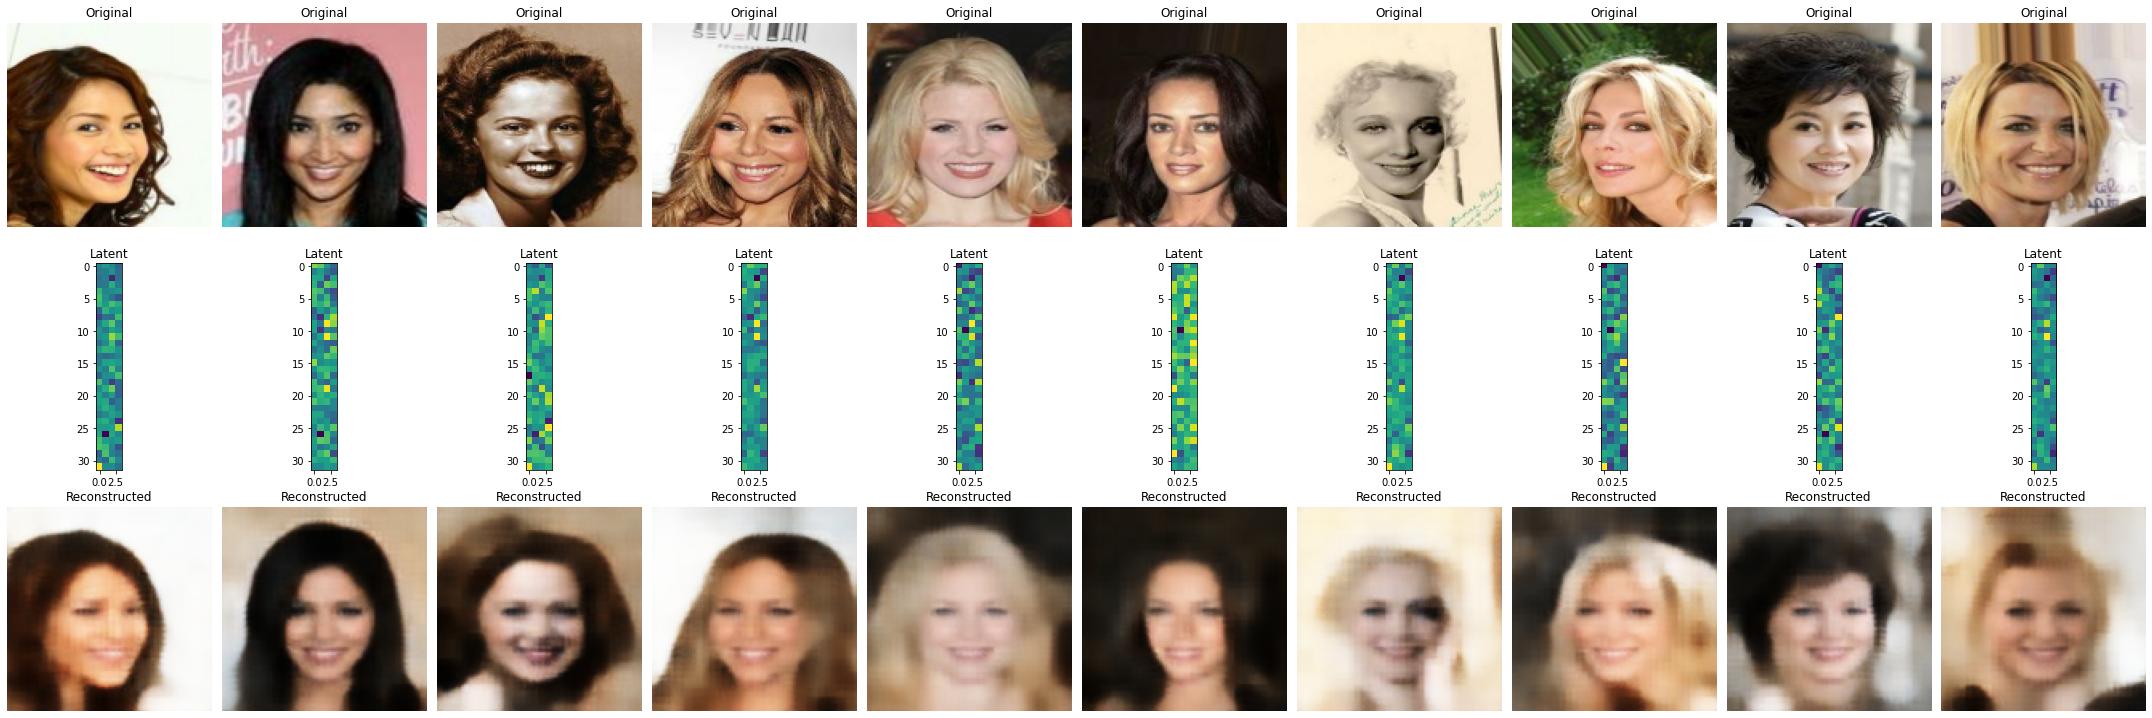

In [7]:
TestToPlot = Test.unbatch().take(10)
ImgToPlot = []
for img in TestToPlot:
    ImgToPlot.append(img[0])
latent = VAE_model_encode_L2.predict(np.array(ImgToPlot))

plt.figure(figsize=(30,10))
for i,_ in enumerate(ImgToPlot):
    plt.subplot(3,10,i+1)
    plt.title("Original")
    plt.imshow(ImgToPlot[i])
    plt.axis(False)
    
    plt.subplot(3,10,10 + i + 1)
    plt.title("Latent")
#     plt.scatter(latent[i].reshape(32,4)[:,0], latent[i].reshape(64,2)[:,1])
    plt.imshow(latent[i].reshape(32,4))
    
    plt.subplot(3,10,20 + i+ 1)
    plt.title("Reconstructed")
    plt.imshow(tf.squeeze(decoderL2(tf.expand_dims(latent[i],axis=0))))
    plt.axis(False)    

plt.tight_layout()

## L2: Plot 10 generated images by randomly sample the latent vectors

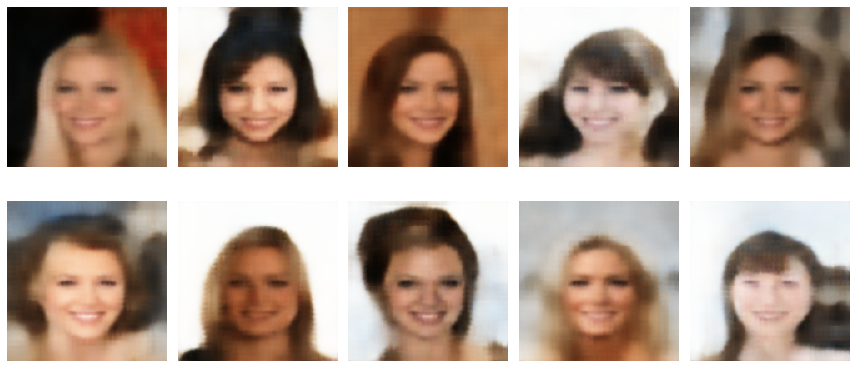

In [8]:
#Ten generated
Num_to_generate = 10
ToGenerate_take = Train.unbatch().take(250)
ImgToPlot = []
for img in ToGenerate_take:
    ImgToPlot.append(img[0])
ToGenerate = VAE_model_encode_L2.predict(np.array(ImgToPlot))
#Random Permutate and sample from latent vector
np.take(ToGenerate,np.random.permutation(ToGenerate.shape[0]),axis=0,out=ToGenerate);
idx_to_use_to_generate = np.random.choice(range(len(ToGenerate)), Num_to_generate)

plt.figure(figsize=(12,6))
for i,idx in enumerate(idx_to_use_to_generate):
    plt.subplot(2,5,i+1)
    plt.imshow(tf.squeeze(decoderL2(tf.expand_dims(ToGenerate[idx],axis=0))))
    plt.axis(False)
plt.tight_layout()

## L2: FID

In [26]:
ds_FID_L2 = Test.unbatch().take(1500)
ds_images = []
for img in ds_FID_L2:
    ds_images.append(img[0])
ds_images = np.array(ds_images)
reconstructed = VAE_L2.predict(ds_images)
print("Reconstructed")
getFID(ds_images,reconstructed)

Reconstructed
FID of your Fake Output: 24.141


In [28]:
ds_FID_L2 = Test.unbatch().take(1500)
ds_images = []
for img in ds_FID_L2:
    ds_images.append(img[0])
ds_latent_L2 = VAE_model_encode_L2.predict(np.array(ds_images))
np.take(ds_latent_L2,np.random.permutation(ds_latent_L2.shape[0]),axis=0,out=ds_latent_L2);
generated_img = decoderL2(ds_latent_L2)
print("Generated")
getFID(ds_images,generated_img)

Generated
FID of your Fake Output: 36.480


# L1 Model

In [29]:
inputsL1 = tf.keras.layers.Input(shape= images_size+(3,), name="InputLayer")
vae_encoderL1 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, activation=tf.nn.leaky_relu, padding="same", kernel_initializer=weight_initialization),
            tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation=tf.nn.leaky_relu, padding="same", kernel_initializer=weight_initialization),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(8, kernel_size=3, strides=2, activation=tf.nn.leaky_relu, padding="same", kernel_initializer=weight_initialization),
            tf.keras.layers.Flatten()], name="EncoderSequence")(inputsL1)

latent_z_mean = tf.keras.layers.Dense(latent_vector_size, name="z_mean", kernel_initializer=weight_initialization)(vae_encoderL1)
latent_z_log_var = tf.keras.layers.Dense(latent_vector_size, name="z_log_var", kernel_initializer=weight_initialization)(vae_encoderL1)
latent_layer_encoder = tf.keras.layers.Lambda(func_lantent_sampling, output_shape=(latent_vector_size,))([latent_z_mean, latent_z_log_var])

VAE_model_encode_L1 = tf.keras.Model(inputsL1, latent_layer_encoder)

decoderL1 = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_vector_size,)),
            tf.keras.layers.Dense(8*8*64, kernel_initializer=weight_initialization),
            tf.keras.layers.Reshape(target_shape=(8,8,64)),
            tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation=tf.nn.leaky_relu, padding="same", kernel_initializer=weight_initialization),
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation=tf.nn.leaky_relu, padding="same", kernel_initializer=weight_initialization),
            tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation=tf.nn.leaky_relu, padding="same", kernel_initializer=weight_initialization),
            tf.keras.layers.Conv2DTranspose(3, kernel_size=3, activation=tf.nn.sigmoid, padding="same", kernel_initializer=weight_initialization)],
            name="DecoderSequence")
decoder_VAE_L1 = decoderL1(VAE_model_encode_L1.output)

VAE_L1 = tf.keras.Model(inputsL1, decoder_VAE_L1, name="VAE_L1")

VAE_L1.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=Re_construction_loss(loss_type="l1"))

## L1 Model: Summary

In [30]:
VAE_L1.summary()

Model: "VAE_L1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
EncoderSequence (Sequential)    (None, 512)          22568       InputLayer[0][0]                 
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 128)          65664       EncoderSequence[0][0]            
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 128)          65664       EncoderSequence[0][0]            
_____________________________________________________________________________________________

In [31]:
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                 restore_best_weights=True)
history_VAE_L1 = VAE_L1.fit(Train,
                         epochs=80,
                         shuffle=True,
                         batch_size=batch_size,
                         validation_data = Test,
                         callbacks=[early_stopper])

Epoch 1/80
70/70 [==============================] - 35s 480ms/step - loss: 0.0621 - val_loss: 0.0298
Epoch 2/80
70/70 [==============================] - 15s 217ms/step - loss: 0.0249 - val_loss: 0.0210
Epoch 3/80
70/70 [==============================] - 16s 225ms/step - loss: 0.0192 - val_loss: 0.0177
Epoch 4/80
70/70 [==============================] - 16s 220ms/step - loss: 0.0167 - val_loss: 0.0169
Epoch 5/80
70/70 [==============================] - 16s 219ms/step - loss: 0.0154 - val_loss: 0.0148
Epoch 6/80
70/70 [==============================] - 16s 227ms/step - loss: 0.0144 - val_loss: 0.0140
Epoch 7/80
70/70 [==============================] - 16s 220ms/step - loss: 0.0137 - val_loss: 0.0135
Epoch 8/80
70/70 [==============================] - 16s 226ms/step - loss: 0.0130 - val_loss: 0.0127
Epoch 9/80
70/70 [==============================] - 15s 219ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 10/80
70/70 [==============================] - 15s 218ms/step - loss: 0.0116 - val_lo

## L1: Plot 10 First Test images, Latent Vector, and Reconstructed images

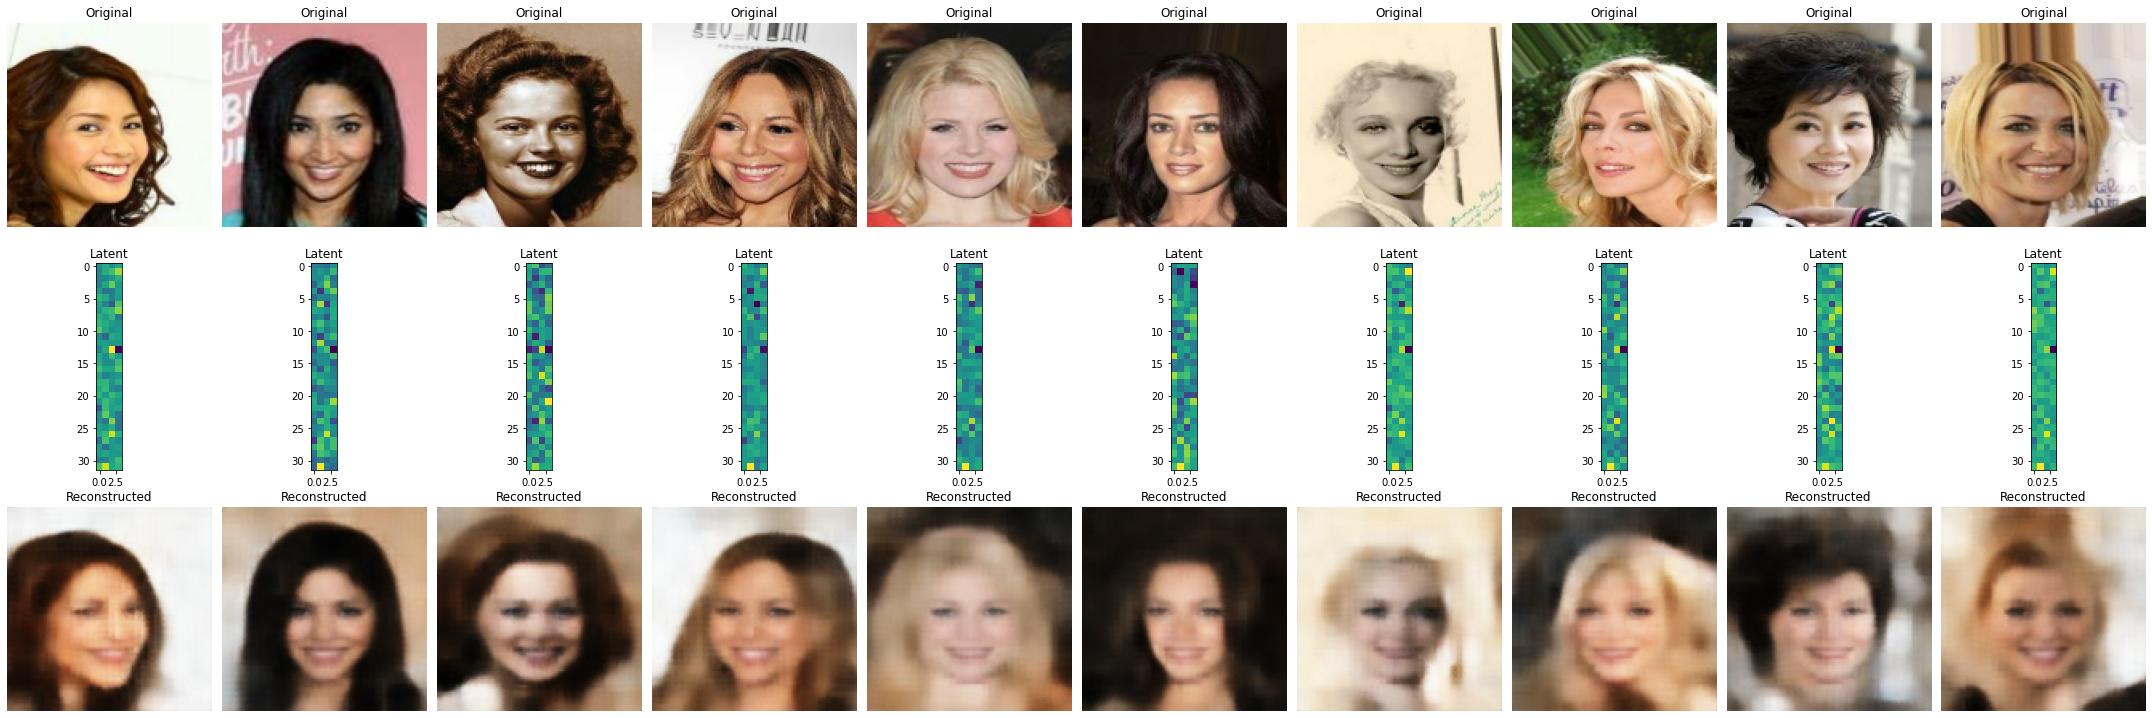

In [32]:
TestToPlot = Test.unbatch().take(10)
ImgToPlot = []
for img in TestToPlot:
    ImgToPlot.append(img[0])
latent = VAE_model_encode_L1.predict(np.array(ImgToPlot))

plt.figure(figsize=(30,10))
for i,_ in enumerate(ImgToPlot):
    plt.subplot(3,10,i+1)
    plt.title("Original")
    plt.imshow(ImgToPlot[i])
    plt.axis(False)
    
    plt.subplot(3,10,10 + i + 1)
    plt.title("Latent")
#     plt.scatter(latent[i].reshape(32,4)[:,0], latent[i].reshape(64,2)[:,1])
    plt.imshow(latent[i].reshape(32,4))
    
    plt.subplot(3,10,20 + i+ 1)
    plt.title("Reconstructed")
    plt.imshow(tf.squeeze(decoderL1(tf.expand_dims(latent[i],axis=0))))
    plt.axis(False)    

plt.tight_layout()

## L1: Plot 10 generated images by randomly sample the latent vectors

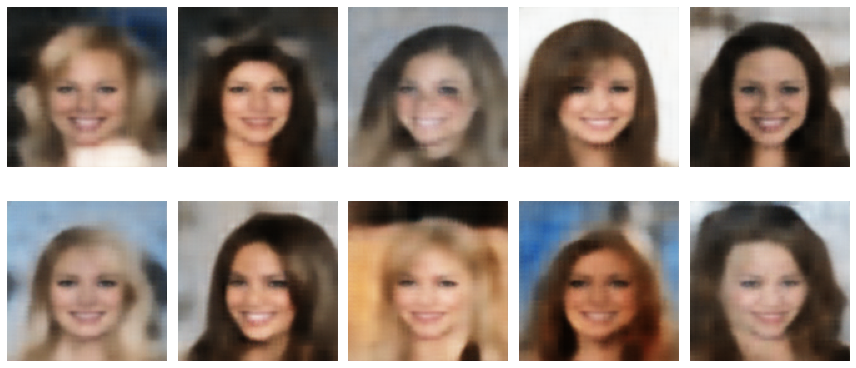

In [33]:
#Ten generated
Num_to_generate = 10
ToGenerate_take = Train.unbatch().take(250)
ImgToPlot = []
for img in ToGenerate_take:
    ImgToPlot.append(img[0])
ToGenerate = VAE_model_encode_L1.predict(np.array(ImgToPlot))
#Random Permutate and sample from latent vector
np.take(ToGenerate,np.random.permutation(ToGenerate.shape[0]),axis=0,out=ToGenerate);
idx_to_use_to_generate = np.random.choice(range(len(ToGenerate)), Num_to_generate)

plt.figure(figsize=(12,6))
for i,idx in enumerate(idx_to_use_to_generate):
    plt.subplot(2,5,i+1)
    plt.imshow(tf.squeeze(decoderL1(tf.expand_dims(ToGenerate[idx],axis=0))))
    plt.axis(False)
plt.tight_layout()

## L1: FID

In [40]:
ds_FID_L1 = Test.unbatch().take(1500)
ds_images = []
for img in ToGenerate_take:
    ds_images.append(img[0])
ds_images = np.array(ds_images)
reconstructed = VAE_L1.predict(ds_images)
print("Reconstructed")
getFID(ds_images,reconstructed)

Reconstructed
FID of your Fake Output: 24.821


In [44]:
ds_latent_L1 = VAE_model_encode_L1.predict(ds_images)
np.take(ds_latent_L1,np.random.permutation(ds_latent_L1.shape[0]),axis=0,out=ds_latent_L1);
generated_img = np.array(decoderL1(ds_latent_L1))
print("Generated")
getFID(ds_images,generated_img)


Generated
FID of your Fake Output: 41.459
